## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions for plotting the data using `matplotlib`. Depending on the data, not all plots will be made. (Hey, I'm just a simple kerneling bot, not a Kaggle Competitions Grandmaster!)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import sys
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
x = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        y = os.path.join(dirname, filename)
        x.append(y)


In [4]:
x[:5]

['/kaggle/input/fold_1/fold_1/hem/UID_H14_23_6_hem.bmp',
 '/kaggle/input/fold_1/fold_1/hem/UID_H14_19_11_hem.bmp',
 '/kaggle/input/fold_1/fold_1/hem/UID_H14_16_5_hem.bmp',
 '/kaggle/input/fold_1/fold_1/hem/UID_H10_91_5_hem.bmp',
 '/kaggle/input/fold_1/fold_1/hem/UID_H14_23_9_hem.bmp']

In [5]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

import itertools

import keras
from keras import utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers import *
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import activations
from keras.regularizers import l2
from keras.engine.topology import get_source_inputs

Using TensorFlow backend.


In [6]:
path = []
p_id = []
for i in x:
    path.append(i)
    p_id.append(i.split('/')[6][:-4])

In [7]:
s_id = []
img_is = []
c = []
lable = []
for i in x:
    v = i.split("_")
    s_id.append(v[3])
    img_is.append(v[4])
    c.append(v[5])
    lable.append(v[6][:-4])

In [8]:
data_tr = pd.DataFrame()
data_tr["Patient_ID"] = p_id
data_tr["path"] = path
data_tr['image'] = data_tr['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 100))))
data_tr["subject_id"] = s_id
data_tr["image_id"] = img_is
data_tr["cell_no"] = c
data_tr["labels"] = lable
data_tr["labels"] = data_tr["labels"].apply(lambda x: 1 if x == 'all' else 0).astype(np.bool)

In [9]:
S_id = []
for i in s_id:
    if i[0] == 'H':
        S_id.append(i[1:])
    else:
        S_id.append(i)

In [10]:
data_tr["subject_id"] = S_id

In [11]:
data_tr["subject_id"] = data_tr["subject_id"].apply(lambda x: x[1:] if x[0] == "h" else x)

In [12]:
data_tr.sample(5)

,Patient_ID,path,image,subject_id,image_id,cell_no,labels
5827,UID_25_5_10_all,/kaggle/input/fold_2/fold_2/all/UID_25_5_10_al...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",25,5,10,True
6841,UID_67_7_2_all,/kaggle/input/fold_2/fold_2/all/UID_67_7_2_all...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",67,7,2,True
2020,UID_51_137_1_all,/kaggle/input/fold_1/fold_1/all/UID_51_137_1_a...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",51,137,1,True
3640,UID_H9_21_2_hem,/kaggle/input/fold_2/fold_2/hem/UID_H9_21_2_he...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",9,21,2,False
6418,UID_67_23_1_all,/kaggle/input/fold_2/fold_2/all/UID_67_23_1_al...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",67,23,1,True


(-0.5, 99.5, 99.5, -0.5)

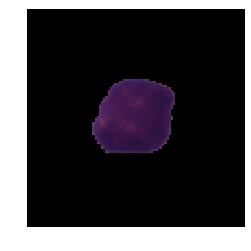

In [13]:
plt.imshow(data_tr["image"][8])
plt.axis("off")

True     7272
False    3389
Name: labels, dtype: int64

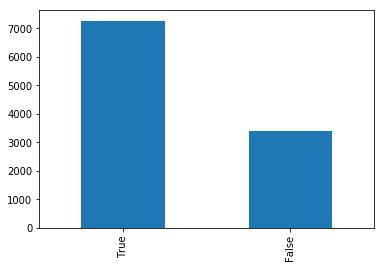

In [14]:
data_tr["labels"].value_counts().plot(kind = "bar")
data_tr["labels"].value_counts()

Text(0.5, 1.0, 'Subject Id distribution')

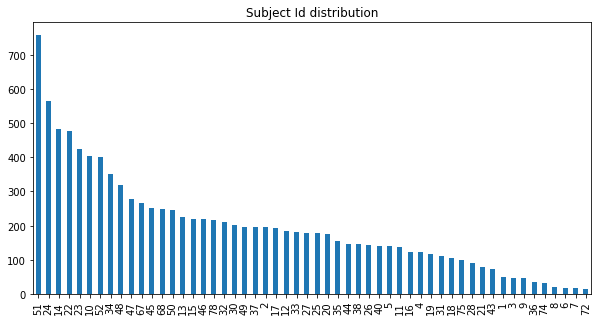

In [15]:
plt.rcParams['figure.figsize'] = [10, 5]
data_tr['subject_id'].value_counts().plot(kind = 'bar')
plt.title("Subject Id distribution")

In [16]:
data_tr["cell_no"] = data_tr["cell_no"].astype(np.int32)
data_tr["subject_id"] = data_tr["subject_id"].astype(np.int32)
data_tr["image_id"] = data_tr["image_id"].astype(np.int32)
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10661 entries, 0 to 10660
Data columns (total 7 columns):
Patient_ID    10661 non-null object
path          10661 non-null object
image         10661 non-null object
subject_id    10661 non-null int32
image_id      10661 non-null int32
cell_no       10661 non-null int32
labels        10661 non-null bool
dtypes: bool(1), int32(3), object(3)
memory usage: 385.3+ KB


In [17]:
X = data_tr.drop(["labels"], axis = 1)
y = data_tr["labels"]

In [18]:
X[:1]

,Patient_ID,path,image,subject_id,image_id,cell_no
0,UID_H14_23_6_hem,/kaggle/input/fold_1/fold_1/hem/UID_H14_23_6_h...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",14,23,6


In [19]:
y[0]

False

%age of label value 0 in training dataset 0.31812851782363977
%age of label value 0 in test dataset 0.316924519456165


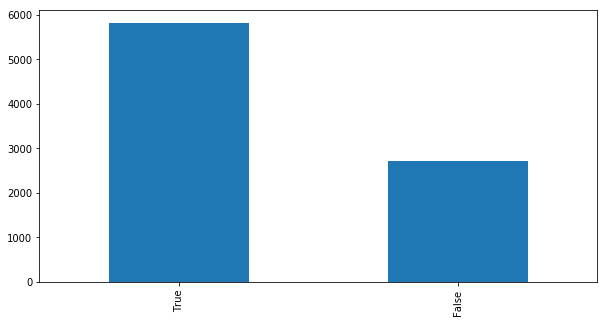

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

y_train.value_counts().plot(kind = "bar")

print("%age of label value 0 in training dataset", 
      y_train.value_counts()[0]/(y_train.value_counts()[0]+y_train.value_counts()[1]))
print("%age of label value 0 in test dataset", 
      y_test.value_counts()[0]/(y_test.value_counts()[0]+y_test.value_counts()[1]))

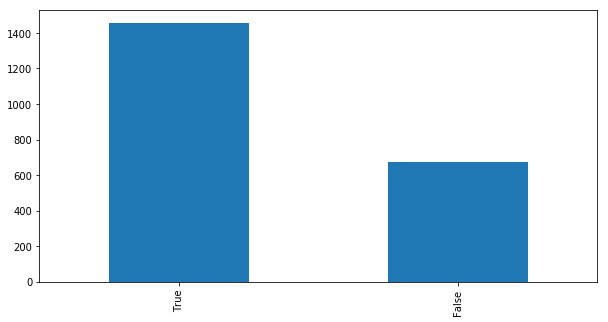

In [21]:
y_test.value_counts().plot(kind = "bar")

In [22]:
shit = x_train
shit2 = x_test
sh = y_train

In [23]:
y_train[:5]

9759      True
10290     True
6930      True
3038      True
4058     False
Name: labels, dtype: bool

In [24]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

In [25]:
x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [26]:
y_train[:5]

9759      True
10290     True
6930      True
3038      True
4058     False
Name: labels, dtype: bool

In [27]:
test = []
for i in y_test:
    if i == False:
        test.append(0)
    elif i == True:
        test.append(1)

In [28]:
tra = []
for i in y_train:
    if i == False:
        tra.append(0)
    elif i == True:
        tra.append(1)

In [29]:
test[:5]

[1, 1, 0, 1, 0]

In [30]:
tra[:5]

[1, 1, 1, 1, 0]

In [31]:
y_test[:5]

6830     True
8600     True
4080    False
3079     True
582     False
Name: labels, dtype: bool

In [32]:
x_train.shape

(8528, 100, 100, 3)

In [33]:
x = np.reshape(x_train, (x_train.shape[0], -1))

In [34]:
x.shape

(8528, 30000)

In [35]:
xt = np.reshape(x_test, (x_test.shape[0], -1))

In [36]:
xt.shape

(2133, 30000)

In [37]:
x[:5]

array([[-0.40293467, -0.40293467, -0.40293467, ..., -0.40293467,
        -0.40293467, -0.40293467],
       [-0.40293467, -0.40293467, -0.40293467, ..., -0.40293467,
        -0.40293467, -0.40293467],
       [-0.40293467, -0.40293467, -0.40293467, ..., -0.40293467,
        -0.40293467, -0.40293467],
       [-0.40293467, -0.40293467, -0.40293467, ..., -0.40293467,
        -0.40293467, -0.40293467],
       [-0.40293467, -0.40293467, -0.40293467, ..., -0.40293467,
        -0.40293467, -0.40293467]])

In [38]:
trai = np.reshape(tra, len(tra) , 1)

In [39]:
tes = np.reshape(test, len(test) , 1)

In [40]:
trai[:5]

array([1, 1, 1, 1, 0])

In [41]:
tes[:5]

array([1, 1, 0, 1, 0])

# **SVM**

In [42]:
x.shape, len(tra), xt.shape

((8528, 30000), 8528, (2133, 30000))

In [43]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear', verbose = 1) # Linear Kernel

#Train the model using the training sets
clf.fit(x, tra)

#Predict the response for test dataset
y_pred = clf.predict(xt)

[LibSVM]

In [44]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(tes, y_pred))
metrics.classification_report

Accuracy: 0.776840131270511


<function sklearn.metrics.classification.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)>

In [45]:
print("report:",metrics.classification_report(tes, y_pred))

report:               precision    recall  f1-score   support

           0       0.64      0.69      0.66       676
           1       0.85      0.82      0.83      1457

    accuracy                           0.78      2133
   macro avg       0.74      0.75      0.75      2133
weighted avg       0.78      0.78      0.78      2133



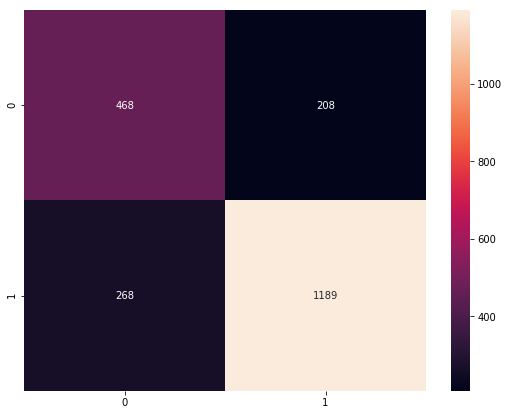

In [46]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(tes, y_pred)
import seaborn as sn
import pandas as pd
plt.figure(figsize = (9,7))
sn.heatmap(matrix, annot=True, fmt="d")

# **Decision Tree Classifier**

In [47]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(x, tra)
dtree_pred = dtree.predict(xt)

In [48]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(tes, dtree_pred))

Accuracy: 0.7726207219878106


In [49]:
print("report:",metrics.classification_report(tes, dtree_pred))

report:               precision    recall  f1-score   support

           0       0.64      0.66      0.65       676
           1       0.84      0.82      0.83      1457

    accuracy                           0.77      2133
   macro avg       0.74      0.74      0.74      2133
weighted avg       0.78      0.77      0.77      2133



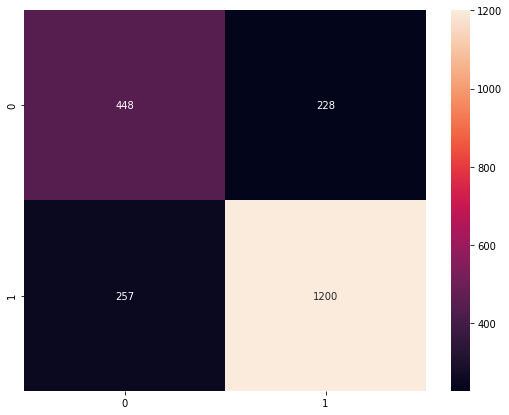

In [50]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(tes, dtree_pred)
import seaborn as sn
import pandas as pd
plt.figure(figsize = (9,7))
sn.heatmap(matrix, annot=True, fmt="d")

# **Random Forest Classifier**

In [51]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)
rforest.fit(x, tra)
predictions = rforest.predict(xt)

In [52]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(tes, predictions))

Accuracy: 0.8209095171120487


In [53]:
print("report:",metrics.classification_report(tes, predictions))

report:               precision    recall  f1-score   support

           0       0.78      0.61      0.68       676
           1       0.83      0.92      0.88      1457

    accuracy                           0.82      2133
   macro avg       0.81      0.76      0.78      2133
weighted avg       0.82      0.82      0.81      2133



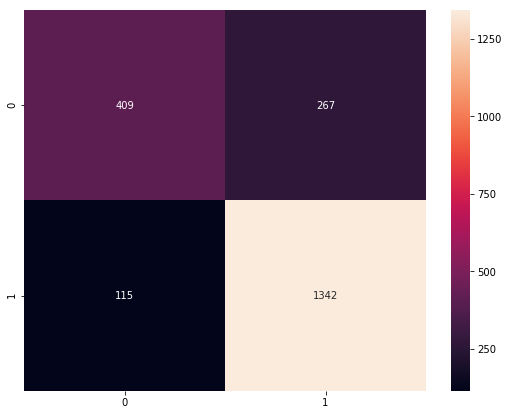

In [54]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(tes, predictions)
import seaborn as sn
import pandas as pd
plt.figure(figsize = (9,7))
sn.heatmap(matrix, annot=True, fmt="d")

# **MLPClassifier**

In [55]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(16, 8, 4, 4), verbose = 1)
history = mlp.fit(x, tra)
mlp_pred = mlp.predict(xt)

Iteration 1, loss = 0.74344402
Iteration 2, loss = 0.73331953
Iteration 3, loss = 0.72403843
Iteration 4, loss = 0.71535221
Iteration 5, loss = 0.70728619
Iteration 6, loss = 0.69985197
Iteration 7, loss = 0.69288079
Iteration 8, loss = 0.68649831
Iteration 9, loss = 0.68055528
Iteration 10, loss = 0.67513126
Iteration 11, loss = 0.67009010
Iteration 12, loss = 0.66549935
Iteration 13, loss = 0.66130325
Iteration 14, loss = 0.65746135
Iteration 15, loss = 0.65393139
Iteration 16, loss = 0.65076392
Iteration 17, loss = 0.64788941
Iteration 18, loss = 0.64528244
Iteration 19, loss = 0.64292579
Iteration 20, loss = 0.64083568
Iteration 21, loss = 0.63891853
Iteration 22, loss = 0.63722777
Iteration 23, loss = 0.63571552
Iteration 24, loss = 0.63435643
Iteration 25, loss = 0.63317508
Iteration 26, loss = 0.63210456
Iteration 27, loss = 0.63118078
Iteration 28, loss = 0.63037863
Iteration 29, loss = 0.62965781
Iteration 30, loss = 0.62904541
Iteration 31, loss = 0.62849907
Iteration 32, los

In [56]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(tes, mlp_pred))

Accuracy: 0.6830754805438349


In [57]:
print("report:",metrics.classification_report(tes, mlp_pred))

report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       676
           1       0.68      1.00      0.81      1457

    accuracy                           0.68      2133
   macro avg       0.34      0.50      0.41      2133
weighted avg       0.47      0.68      0.55      2133



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


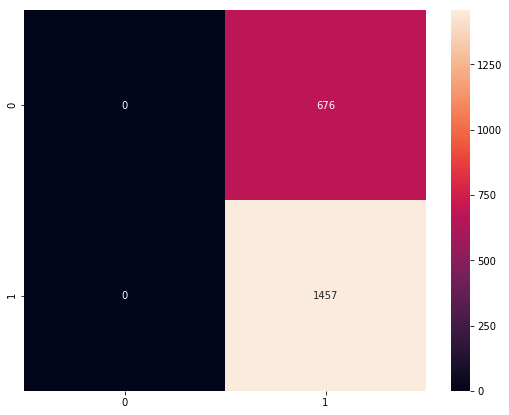

In [58]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(tes, mlp_pred)
import seaborn as sn
import pandas as pd
plt.figure(figsize = (9,7))
sn.heatmap(matrix, annot=True, fmt="d")

# **MLP2**

In [59]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), verbose = 1)
history = mlp.fit(x, tra)
mlp2_pred = mlp.predict(xt)

Iteration 1, loss = 0.98191335
Iteration 2, loss = 0.93996164
Iteration 3, loss = 0.92414210
Iteration 4, loss = 0.90879966
Iteration 5, loss = 0.89394020
Iteration 6, loss = 0.87966553
Iteration 7, loss = 0.86583917
Iteration 8, loss = 0.85260869
Iteration 9, loss = 0.83984619
Iteration 10, loss = 0.82762598
Iteration 11, loss = 0.81588293
Iteration 12, loss = 0.80469019
Iteration 13, loss = 0.79392774
Iteration 14, loss = 0.78371532
Iteration 15, loss = 0.77390774
Iteration 16, loss = 0.76461692
Iteration 17, loss = 0.75575304
Iteration 18, loss = 0.74732808
Iteration 19, loss = 0.73929622
Iteration 20, loss = 0.73172692
Iteration 21, loss = 0.72452404
Iteration 22, loss = 0.71769377
Iteration 23, loss = 0.71123643
Iteration 24, loss = 0.70516207
Iteration 25, loss = 0.69941417
Iteration 26, loss = 0.69401446
Iteration 27, loss = 0.68889448
Iteration 28, loss = 0.68413774
Iteration 29, loss = 0.67960572
Iteration 30, loss = 0.67541185
Iteration 31, loss = 0.67144340
Iteration 32, los

In [60]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(tes, mlp2_pred))

Accuracy: 0.6830754805438349


In [61]:
print("report:",metrics.classification_report(tes, mlp2_pred))

report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       676
           1       0.68      1.00      0.81      1457

    accuracy                           0.68      2133
   macro avg       0.34      0.50      0.41      2133
weighted avg       0.47      0.68      0.55      2133



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


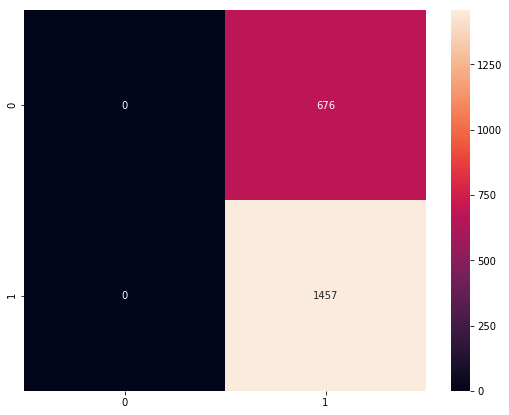

In [62]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(tes, mlp2_pred)
import seaborn as sn
import pandas as pd
plt.figure(figsize = (9,7))
sn.heatmap(matrix, annot=True, fmt="d")



# **KNN**

In [63]:
from sklearn.neighbors import KNeighborsClassifier

#Create a KNN Classifier
nbr = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
nbr.fit(x, tra)

#Predict the response for test dataset
nbr_pred = nbr.predict(xt)

In [64]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(tes, nbr_pred))
metrics.classification_report

Accuracy: 0.7862165963431786


<function sklearn.metrics.classification.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)>

In [65]:
print("report:",metrics.classification_report(tes, nbr_pred))

report:               precision    recall  f1-score   support

           0       0.67      0.65      0.66       676
           1       0.84      0.85      0.84      1457

    accuracy                           0.79      2133
   macro avg       0.75      0.75      0.75      2133
weighted avg       0.78      0.79      0.79      2133



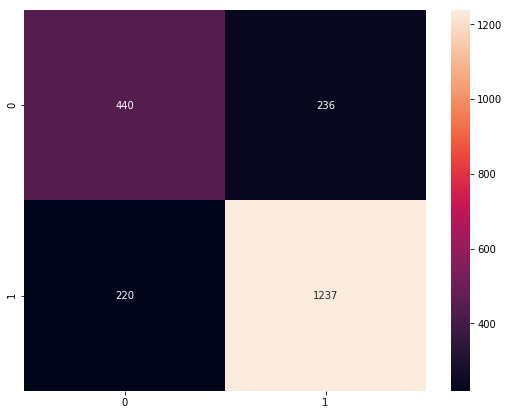

In [66]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(tes, nbr_pred)
import seaborn as sn
import pandas as pd
plt.figure(figsize = (9,7))
sn.heatmap(matrix, annot=True, fmt="d")

# **END**

In [67]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [68]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [69]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
